In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from atusfunclib import load_data
from activitylib import ACTINFO
from wlmetrics import *
import pickle

In [79]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import metrics
from sklearn import model_selection
from sklearn.externals import joblib
from sklearn import base

In [5]:
def compute_mse(est, X, y, k):
    """Calculates the MSE with k fold validation"""
    return -model_selection.cross_val_score(est, X, y, cv=k, scoring='neg_mean_squared_error').mean()

In [81]:
class BaseResEnsembleEstimator(base.BaseEstimator, base.RegressorMixin):

    def __init__(self, base_est, resd_est):
        # Set base estimator and residual estimator
        self.base_est = base_est
        self.resd_est = resd_est

    def fit(self, X, y):
        # Fit base
        self.base_est.fit(X, y)
        # Calculate residual
        residual = y - self.base_est.predict(X)
        # Fit to residual
        self.resd_est.fit(X, residual)
        return self

    def predict(self, X):
        # Sum of base prediction and residual prediction
        return self.base_est.predict(X) + self.resd_est.predict(X)

class DataFrameSelector(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, feature_names=None, dtype=np.int64, ntn=False):
        self.feature_names = feature_names
        self.dtype = dtype
        self.ntn = ntn

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.feature_names:
            Xarr = X[self.feature_names].as_matrix()
        else:
            Xarr = X.as_matrix()

        if self.ntn:
            Xarr = np.nan_to_num(Xarr)     

        return Xarr.astype(self.dtype)


class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def transform(self, X):
        p = self.estimator.predict(X)
        return # 2D array correctly reshaped!!!!

In [7]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [8]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [9]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [10]:
# Split by weekday and weekend/holiday
df_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)]
df_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)]

In [11]:
del df

In [12]:
# Weights for ratio calculation
weights_p = np.array([1.0, 0.2, 1.0, 0.6, 0.6, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.2])
weights_n = np.array([0.0, 1.0, 0.8, 1.0])

In [13]:
# Calculate metrics (i.e. y data)
df_weday_y = pd.DataFrame()
df_wehol_y = pd.DataFrame()

df_weday_y['metric1'] = w_l_balance_weighted_ratio(df_weday, ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                   weights_p, weights_n, N=1)

df_weday_y['metric2'] = w_l_balance_workday(df_weday, workid='0501', hours=10)
df_weday_y['metric3'] = w_l_balance_personalcare(df_weday)
df_weday_y['metric4'] = w_l_balance_leisuresocial(df_weday)
df_weday_y['metric5'] = w_l_balance_housework(df_weday, hours=3)

df_wehol_y['metric1'] = w_l_balance_weighted_ratio(df_wehol, ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                   weights_p, weights_n, N=1)

df_wehol_y['metric2'] = w_l_balance_workday(df_wehol, workid='0501', hours=10)
df_wehol_y['metric3'] = w_l_balance_personalcare(df_wehol)
df_wehol_y['metric4'] = w_l_balance_leisuresocial(df_wehol)
df_wehol_y['metric5'] = w_l_balance_housework(df_wehol, hours=3)

In [14]:
# Features list
features = ['TEAGE', 'TESEX', 'GEMETSTA', 'GESTFIPS',
            'TELFS', 'TRDPFTPT',
            'TRSPPRES', 'TESPEMPNOT',
            'TESCHENR', 'TESCHLVL', 'PEEDUCA',
            'PTDTRACE',
            'TRCHILDNUM', 'TRNUMHOU',
            'TRMJOCGR', 'TRDTOCC1',
            'TRMJIND1', 'TEIO1COW', 'TRERNWA',
            'TUDIS']
catfeatures = ['GEMETSTA', 'GESTFIPS',
               'TELFS', 'TRDPFTPT',
               'TRSPPRES', 'TESPEMPNOT',
               'TESCHENR', 'TESCHLVL',
               'PTDTRACE',
               'TRMJOCGR', 'TRDTOCC1',
               'TRMJIND1', 'TEIO1COW',
               'TUDIS']
numcats = [4, 57, 6, 3, 4, 3, 3, 3, 27, 7, 23, 14, 9, 4]

In [15]:
# Features matrix (i.e. X data)
df_weday_X = df_weday[features]
df_wehol_X = df_wehol[features]

In [16]:
# Split train-test indices
rs = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

train_wd, test_wd = rs.split(df_weday).next()
train_wh, test_wh = rs.split(df_wehol).next()

In [17]:
del df_weday
del df_wehol

## Set training and test data

In [32]:
m = 'metric3'

y = df_weday_y[m].as_matrix()[train_wd]
X = df_weday_X.iloc[train_wd]

y_test = df_weday_y[m].as_matrix()[test_wd]
X_test = df_weday_X.iloc[test_wd]

## Build estimator for age, education, weekly income, child number, household number

In [25]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('impute1', Imputer(missing_values='NaN', strategy='median', axis=0)),
    ('scaler1', StandardScaler()),
    ('quadrat', PolynomialFeatures(degree=3, include_bias=False))
])

# Linear features
lintrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA', 'TRERNWA', 'TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0))
])

est = Pipeline([
    ('union01', FeatureUnion([
        ('lintran', lintrans),
        ('agetran', agetrans)
    ])),
    ('scaler2', StandardScaler()),
    ('ensembl', BaseResEnsembleEstimator(Ridge(alpha=1),
                                         RandomForestRegressor(n_estimators=250,
                                                               max_depth=20,
                                                               min_samples_leaf=1,
                                                               random_state=42)))
])

In [21]:
# Grid search CV
gridsearch = GridSearchCV(est,
                          {'ensembl__resd_est__n_estimators': [50, 100, 150, 200, 250],
                           'ensembl__base_est__alpha': [0.5, 1, 2, 4]
                          },
                          cv=3,
                          n_jobs=-1,
                          scoring='neg_mean_squared_error',
                          verbose=True)

In [23]:
gridsearch.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('lintran', Pipeline(steps=[('featse2', DataFrameSelector(dtype=<type 'float'>,
         feature_names=['PEEDUCA', 'TRERNWA', 'TRCHILDNUM', 'TRNUMHOU'],
         ntn=False)), ('impute2', Imputer(axis=0, copy=True, missing_values='NaN...timators=200, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'ensembl__resd_est__n_estimators': [50, 100, 150, 200, 250], 'ensembl__base_est__alpha': [0.5, 1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [24]:
gridsearch.best_params_

{'ensembl__base_est__alpha': 1, 'ensembl__resd_est__n_estimators': 250}

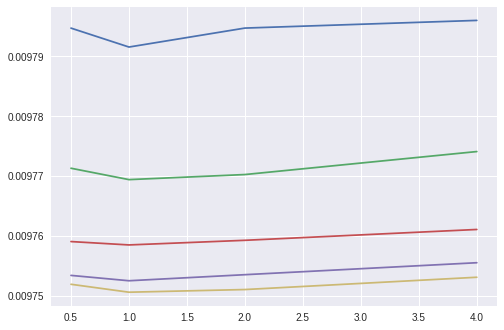

In [64]:
# Graphs
plt.plot([0.5, 1, 2, 4], -gridsearch.cv_results_['mean_test_score'].reshape((4,5)));

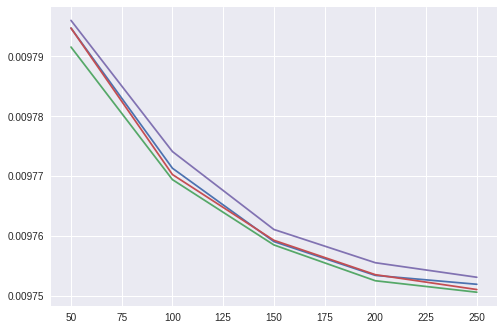

In [65]:
plt.plot([50, 100, 150, 200, 250], -gridsearch.cv_results_['mean_test_score'].reshape((4,5)).T);

## Fitting using the best parameters on training set for a specific metric

In [26]:
est.fit(X, y)

Pipeline(steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('lintran', Pipeline(steps=[('featse2', DataFrameSelector(dtype=<type 'float'>,
         feature_names=['PEEDUCA', 'TRERNWA', 'TRCHILDNUM', 'TRNUMHOU'],
         ntn=False)), ('impute2', Imputer(axis=0, copy=True, missing_values='NaN...timators=250, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)))])

In [27]:
est.score(X, y)

0.38802773459371664

In [28]:
compute_mse(est, X, y, 3)

0.0097505580760519264

In [29]:
est.predict(df_weday_X.head(25))

array([ 0.56797411,  0.42223098,  0.39572272,  0.39933358,  0.39456796,
        0.41353731,  0.30751339,  0.42264508,  0.43245048,  0.40884236,
        0.42183079,  0.4026533 ,  0.48340988,  0.36989774,  0.39886369,
        0.488044  ,  0.4245874 ,  0.43418039,  0.39231457,  0.41367929,
        0.39490963,  0.36327241,  0.35203674,  0.42567767,  0.44614813])

In [30]:
y[:25]

array([ 0.62222222,  0.33472222,  0.34375   ,  0.425     ,  0.39583333,
        0.39583333,  0.45833333,  0.40972222,  0.31388889,  0.26388889,
        0.375     ,  0.37152778,  0.68055556,  0.40277778,  0.39583333,
        0.47222222,  0.41666667,  0.17708333,  0.42708333,  0.43055556,
        0.42013889,  0.30902778,  0.37152778,  0.45138889,  0.51041667])

In [33]:
compute_mse(est, X_test, y_test, 3)

0.010160520709170971

## Build estimator for all categorical features

In [72]:
# Use one-hot-encoding followed by truncated SVD to reduce feature count
est_cat = Pipeline([
    ('featse1', DataFrameSelector(feature_names=catfeatures, dtype=np.int64, ntn=True)),
    ('encode1', OneHotEncoder(n_values=numcats, handle_unknown='ignore')),
    ('trunsvd', TruncatedSVD(n_components=100, random_state=42)),
    ('erfregr', ExtraTreesRegressor(n_estimators=100,
                                    max_depth=20,
                                    min_samples_leaf=1,
                                    random_state=42))
])

In [67]:
# Grid search CV
gridsearch_cat = GridSearchCV(est_cat,
                              {'trunsvd__n_components': [15, 30, 100],
                               'erfregr__n_estimators': [50, 100, 200]
                              },
                              cv=3,
                              n_jobs=-1,
                              scoring='neg_mean_squared_error',
                              verbose=True)

In [68]:
gridsearch_cat.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'TESCHLVL', 'PTDTRACE', 'TRMJOCGR', 'TRDTOCC1', 'TRMJIND1', 'TEIO1COW', 'TUDIS'],
         ntn=True)), ('encode1', OneHotEncoder...estimators=100, n_jobs=1, oob_score=False, random_state=42,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'trunsvd__n_components': [15, 30, 100], 'erfregr__n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [69]:
gridsearch_cat.best_params_

{'erfregr__n_estimators': 200, 'trunsvd__n_components': 100}

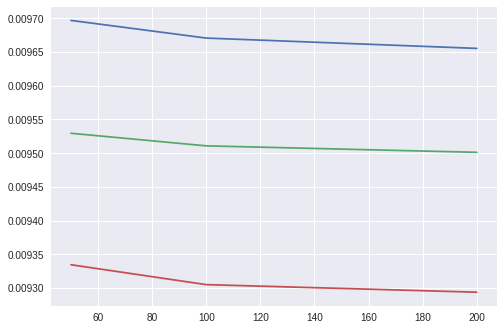

In [71]:
plt.plot([50, 100, 200], -gridsearch_cat.cv_results_['mean_test_score'].reshape((3,3)));

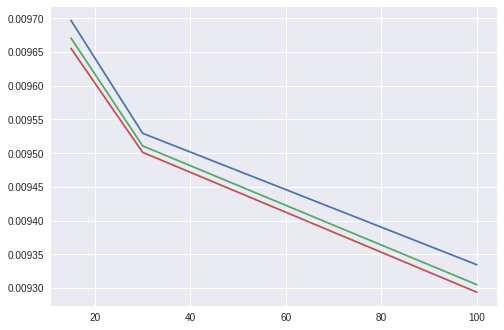

In [73]:
plt.plot([15, 30, 100], -gridsearch_cat.cv_results_['mean_test_score'].reshape((3,3)).T);

## Fitting using the best parameters on training set for a specific metric

In [74]:
est_cat.fit(X, y)

Pipeline(steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'TESCHLVL', 'PTDTRACE', 'TRMJOCGR', 'TRDTOCC1', 'TRMJIND1', 'TEIO1COW', 'TUDIS'],
         ntn=True)), ('encode1', OneHotEncoder...estimators=100, n_jobs=1, oob_score=False, random_state=42,
          verbose=0, warm_start=False))])

In [75]:
est_cat.score(X, y)

0.3560504814724787

In [76]:
compute_mse(est_cat, X, y, 3)

0.0093048617629365362

In [77]:
est_cat.predict(df_weday_X.head(15))

array([ 0.57569521,  0.48397165,  0.39241994,  0.49942573,  0.38777228,
        0.4095655 ,  0.35235989,  0.39607177,  0.42542265,  0.38325979,
        0.38930364,  0.40840095,  0.42754532,  0.39841393,  0.41071614])

In [78]:
y[:15]

array([ 0.62222222,  0.33472222,  0.34375   ,  0.425     ,  0.39583333,
        0.39583333,  0.45833333,  0.40972222,  0.31388889,  0.26388889,
        0.375     ,  0.37152778,  0.68055556,  0.40277778,  0.39583333])

## Combined model that uses a linear combination of continuous and categorical models

In [ ]:
full_est = Pipeline([
    ('union', FeatureUnion([
        ('conest', EstimatorTransformer(est)),
        ('catest', EstimatorTransformer(est_cat))
    ])),
    ('combi', LinearRegression())
])